# EE-411 TP session 12

Total 11 questions, 1 point each. Max score is 6!

## Part 1: Principal Component Analysis

In this set of exercises we will play a little bit with PCA, first introducing it in a very simple case, and then showing its potential in an interesting example. PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engineering, and much more.

**What you will learn today:** In this notebook, we will see how to implement PCA using our old friend SciKitLearn.

In [1]:
#We import th usual packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sla

## Introducing PCA

_This excercise relies heavily on an example taken from the Python Data Science Handbook, by Jake VanderPlas_

Principal component analysis is a fast and flexible unsupervised method for dimensionality reduction in data.

 Its behavior is easier to visualize by looking at a two-dimensional dataset. 
 
 Let's consider the following 200 points in a 2D plane:

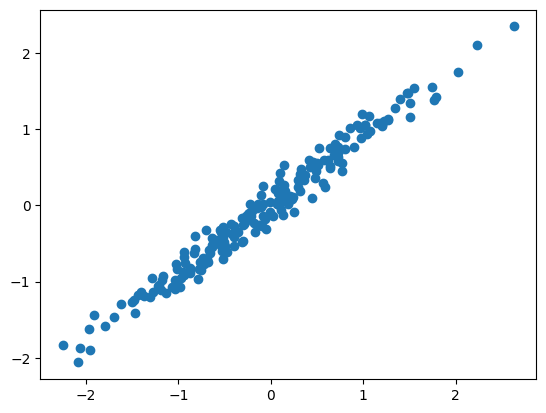

In [2]:
rng = np.random.RandomState(0) #initialize seed
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1]);

By eye, it is clear that there is a nearly linear relationship between the x and y variables, but the problem setting here is slightly different from the usual linear regression: rather than attempting to predict the y values from the x values, the unsupervised learning problem attempts to learn about the relationship between the x and y values.

In PCA, this relationship is quantified by finding a list of the principal axes in the data, and using those axes to describe the dataset.

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

Giving the dataset to the function `fit`, the model learns some quantities from the data, most importantly tha *components* and the *explained variance*:



In [4]:
pca.components_

array([[ 0.739393  ,  0.67327408],
       [-0.67327408,  0.739393  ]])

In [5]:
pca.explained_variance_

array([1.48668691, 0.01057775])

To see what these numbers mean, let's visualize them as vectors over the input data, using the "components" to define the direction of the vector, and the "explained variance" to define the squared-length of the vector:

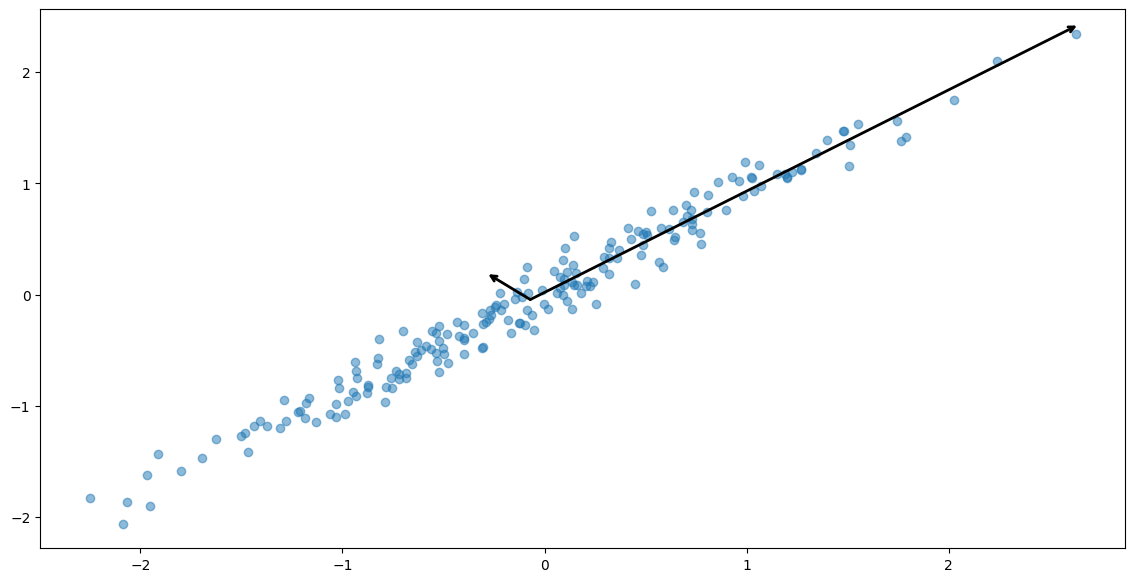

In [6]:
#to draw a vector going from the point v0 to the point v1
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

plt.figure(figsize=(14,7))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)


These vectors represent the principal axes of the data, and the length of the vector is an indication of how "important" that axis is in describing the distribution of the data—more precisely, it is a measure of the variance of the data when projected onto that axis. The projection of each data point onto the principal axes are the "principal components" of the data.

## Dimensionality reduction 

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

Here is an example of using PCA as a dimensionality reduction transform, using the same data as before:

In [7]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


The transformed data has been reduced to a single dimension. To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data:

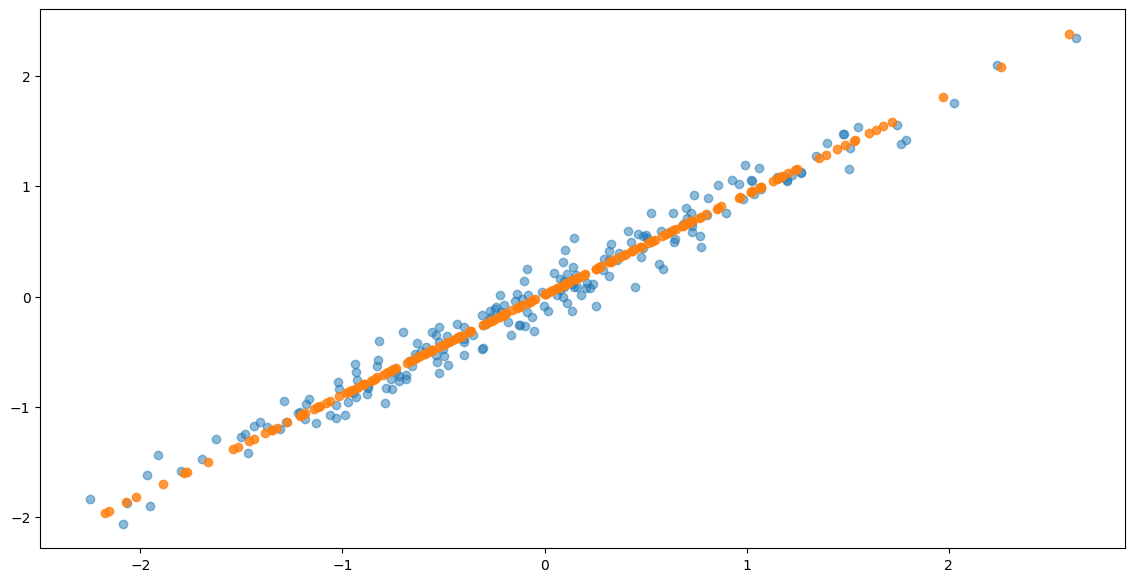

In [8]:
X_new = pca.inverse_transform(X_pca)
plt.figure(figsize=(14,7))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)

This makes clear what a PCA dimensionality reduction means: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance. The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

## PCA as Noise filtering

PCA can also be used as a filtering approach for noisy data. The idea is this: any components with variance much larger than the effect of the noise should be relatively unaffected by the noise. So if you reconstruct the data using just the largest subset of principal components, you should be preferentially keeping the signal and throwing out the noise.

Let's see how this looks with the digits data. First we will plot several of the input noise-free data:

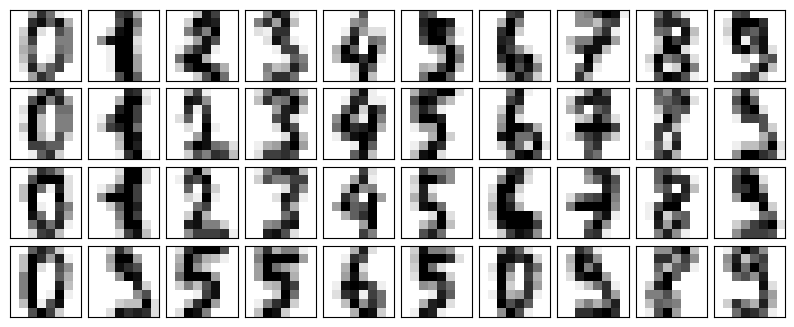

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

Now lets add some random noise to create a noisy dataset, and re-plot it:

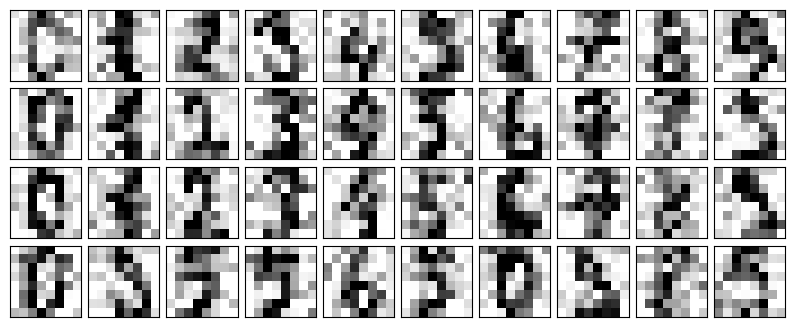

In [10]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

It's clear by eye that the images are noisy, and contain spurious pixels. Let's train a PCA on the noisy data, requesting that the projection preserve 50% of the variance:

In [11]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

Here 50% of the variance amounts to 12 principal components. Now we compute these components, and then use the inverse of the transform to reconstruct the filtered digits:

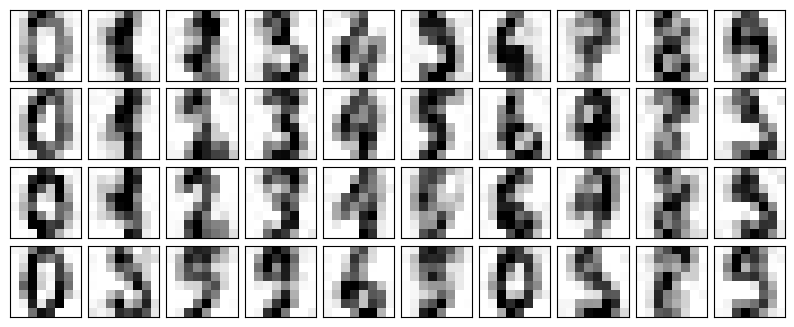

In [12]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data. This can be determined by looking at the `cumulative explained variance ratio` as a function of the number of components:

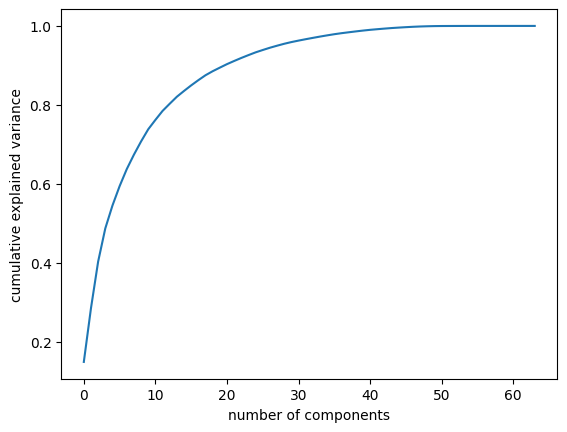

In [13]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total, 64-dimensional variance is contained within the first N components. For example, we see that with the digits the first 10 components contain approximately 75% of the variance, while you need around 50 components to describe close to 100% of the variance.

### Your turn: Eigenfaces

Download the *Labelled Faces in the Wild* (LFW) people dataset from sklearn. This dataset is a collection of pictures of famous people faces. 

By setting `min_faces_per_person=30`, the extracted dataset will only retain pictures of people that have at least 30 different pictures. 

In [14]:
from sklearn.datasets import fetch_lfw_people

In [15]:
# Download the dataset

min_faces_per_person = 30

faces = fetch_lfw_people(min_faces_per_person=min_faces_per_person)

Now we plot the first 10 faces (`dataset.target_images`) together with the corresponding names (`dataset.target_names`) using
`imshow`

In [16]:
faces.target_names.shape

(34,)

George W Bush


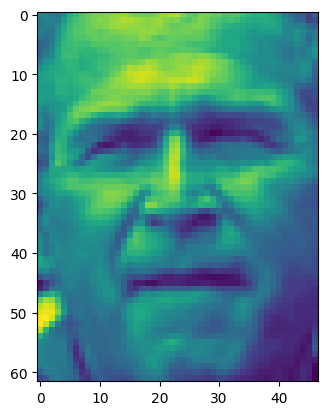

Arnold Schwarzenegger


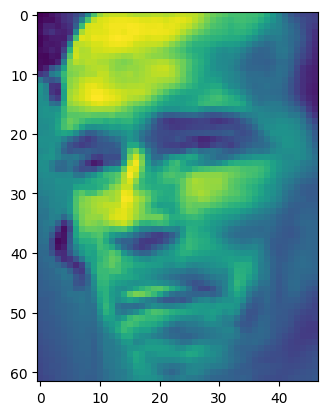

Laura Bush


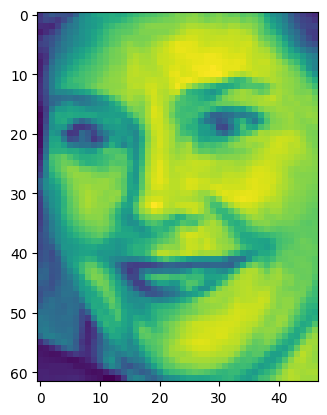

George W Bush


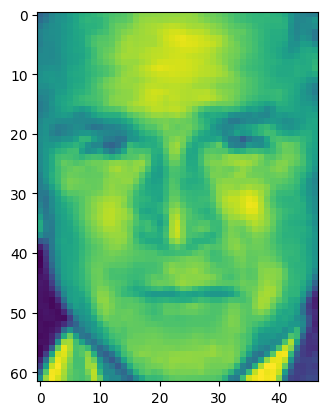

George W Bush


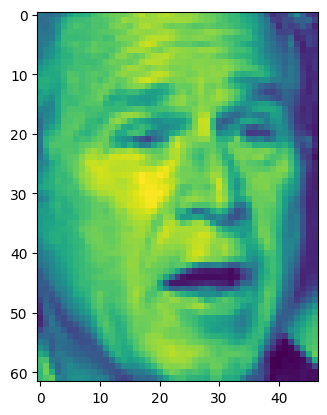

Nestor Kirchner


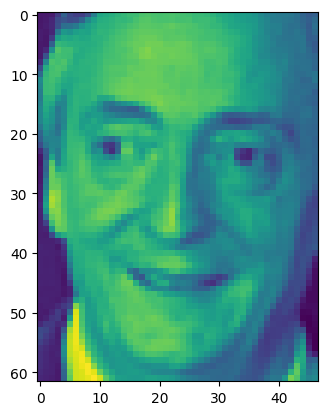

Arnold Schwarzenegger


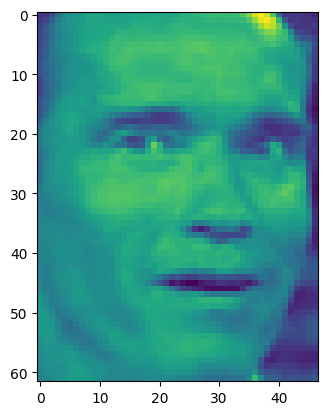

Lleyton Hewitt


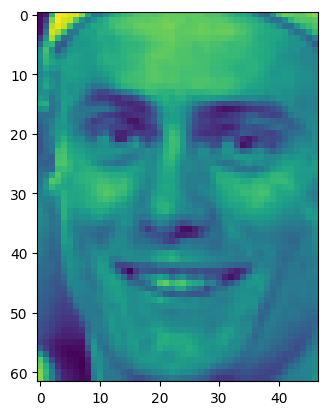

Colin Powell


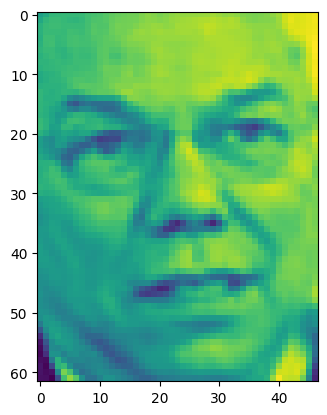

Lleyton Hewitt


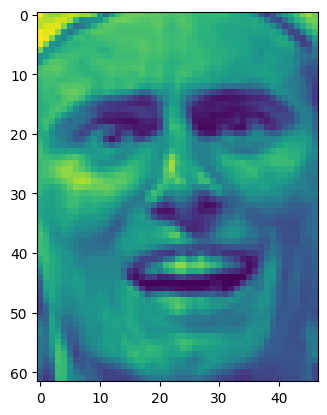

In [17]:
# Print the first 10 faces with the corresponding names

for X, y in zip(faces.images[:10], faces.target[:10]):
    
    print(faces.target_names[y])
    plt.imshow(X)
    plt.show()

In [18]:
print(f"There are {len(faces.data)} images in total, each composed by {len(faces.data[0])} pixels")

There are 2370 images in total, each composed by 2914 pixels


#### 1) In order to obtain a balanced dataset, keep only 30 pictures per person. Then, normalize your data in the range [0, 1].

In [19]:
from sklearn.preprocessing import MinMaxScaler

# Keep only 30 pictures per person
unique_labels, counts = np.unique(faces.target, return_counts=True)
selected_indices = []
for label in unique_labels:
    indices = np.where(faces.target == label)[0]
    selected_indices.extend(indices[:30])

selected_data = faces.data[selected_indices]
selected_target = faces.target[selected_indices]

# Normalize the data in the range [0, 1]
scaler = MinMaxScaler()
X = scaler.fit_transform(selected_data)

print(f"Now there are {len(X)} images.")

Now there are 1020 images.


In [20]:
X.shape

(1020, 2914)

#### 2) Do the PCA on the new dataset, compute the principal components and print their shape

In [21]:
# your code here
pca = PCA(n_components=5)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (1020, 2914)
transformed shape: (1020, 5)


#### 3) Plot, using `imshow`, the first 5 principal components. How do they look like?

In [22]:
X.shape

(1020, 2914)

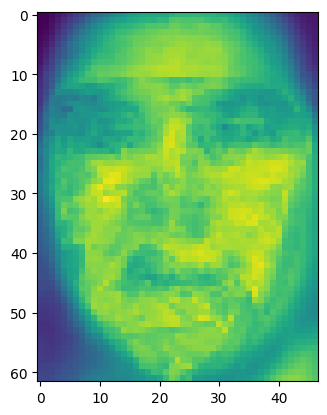

In [23]:
pca = PCA(n_components=5)
pca.fit(X)
components = pca.transform(X)
filtered = pca.inverse_transform(components)
plt.imshow(filtered[0].reshape(62, 47))	


We can't really distinguish which personality it is. We just decerne the eyes and the mouth. So we need to have more dimensions to obtain a known face. 

#### 4) Plot the cumulative explained variance. How many principal components do we need in order to explain the majority of the variance of our faces?

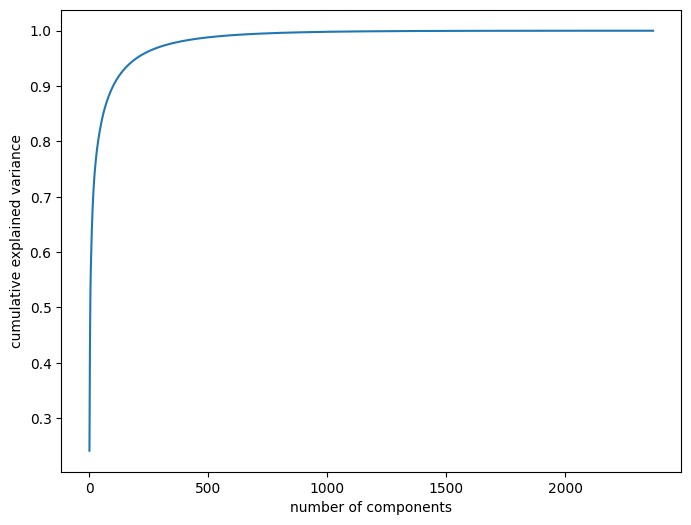

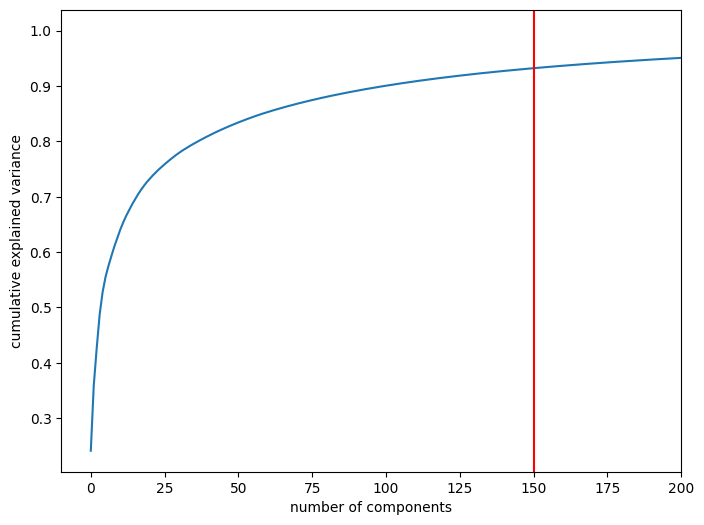

In [24]:
# your code here
pca = PCA().fit(faces.data)
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()


plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(150, c='red')
plt.xlim(-10, 200)
plt.show()

We see that before with only 5 dimension we don't obtain a very good result, so the better number of components to use is 150

#### 5) Compute and plot the projections of four pictures on the first {10, 30, 100, 300, 1000} principal components, using the parameter `n_components` and the method `inverse_transform`.

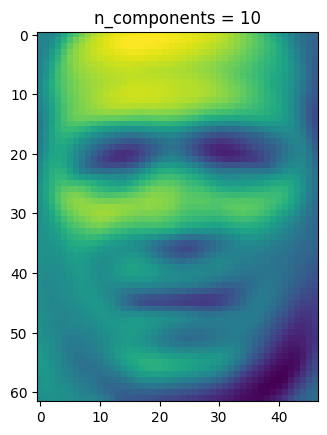

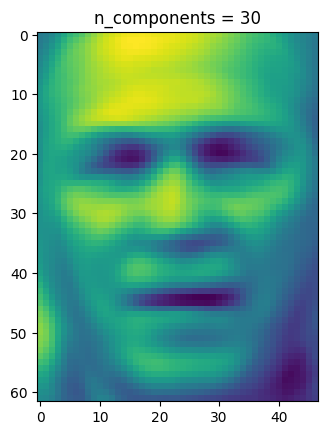

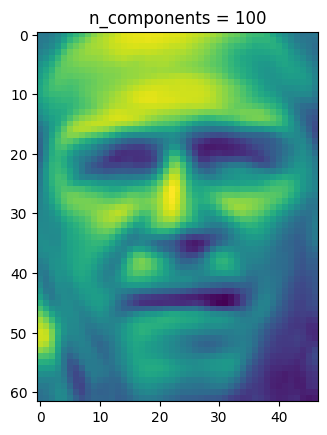

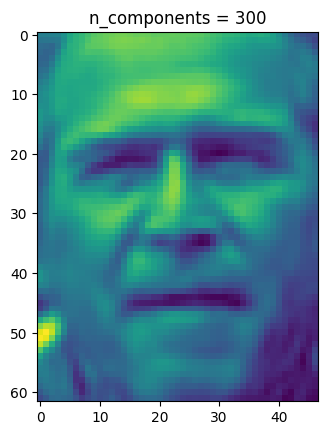

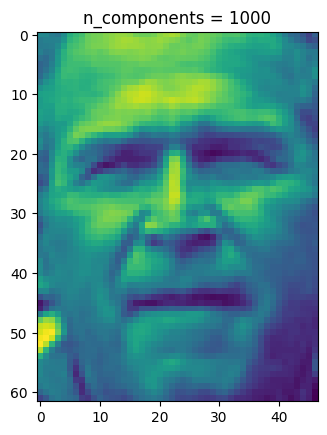

In [25]:
# your code here
n_components = [10,30,100,300,1000]
for n in n_components:
    pca = PCA(n_components=n)
    pca.fit(faces.data)
    components = pca.transform(faces.data)
    filtered = pca.inverse_transform(components)
    plt.imshow(filtered[0].reshape(62, 47))
    plt.title(f"n_components = {n}")
    plt.show()


### Now, we are going to compare the performance of a naive classifier (the predicted label corresponds to the label of the nearest-neighbour image) when using the full pictures and the first 100 PCA projections.

#### 6) First, split your data into a training and a test set.

In [35]:
# your code here
accuracy = []
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, test_size=0.2, random_state=42)

#### 7) Use `sklearn.neighbors.KNeighbordClassifier` with `n_neighbors=1` to fit your training set. Evaluate the performance using the method score on the test set.

In [36]:
# your code here
from sklearn.neighbors import KNeighborsClassifier
n_neighbors = 1
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train, y_train)
print(f"Accuracy with {n_neighbors} neighbors: {knn.score(X_test, y_test)}")
accuracy.append(knn.score(X_test, y_test))

Accuracy with 1 neighbors: 0.3691983122362869


#### 8) Now repeat the training but using only the first 100 principal components. Remember to project the test set also before evaluating the score. Compare with the previous score.

In [37]:
# your code here
pca = PCA(n_components=100)
pca.fit(X_train)
X_pca = pca.transform(X_train)

X_pca_test = pca.transform(X_test)
n_neighbors = 1
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_pca, y_train)
print(f"Accuracy with {n_neighbors} neighbors: {knn.score(X_pca_test, y_test)}")
accuracy.append(knn.score(X_pca_test, y_test))

Accuracy with 1 neighbors: 0.3818565400843882


#### Bonus) When calling `PCA`, set the parameter `whiten=True`. This transformation, called ‘whitening’ and it rescales the principal components to have the same variance. Re-classify the faces and compare the accuracy with the previous ones.

In [38]:
# your code here
pca = PCA(n_components=100, whiten=True)
pca.fit(X_train)
X_pca = pca.transform(X_train)

X_pca_test = pca.transform(X_test)
n_neighbors = 1
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_pca, y_train)
print(f"Accuracy with {n_neighbors} neighbors: {knn.score(X_pca_test, y_test)}")
accuracy.append(knn.score(X_pca_test, y_test))



Accuracy with 1 neighbors: 0.4810126582278481


We obtain a better accuracy with whiten = True. Here there is small summary of the accuracies.

In [57]:
import pandas as pd
model = ['KNN', 'KNN with PCA', 'KNN with PCA and whitening']
df = pd.DataFrame({'model': model, 'accuracy': accuracy})
df['accuracy'] = df['accuracy']*100
df['accuracy'] = df['accuracy'].round(3)
df

,model,accuracy
0,KNN,36.920
1,KNN with PCA,38.186
2,KNN with PCA and whitening,48.101


## Part2: K-means

Now we come back to scikit-learn to see how to easily implement K-means 

9) Generate K Gaussian clusters of $n$ samples. Each cluster has $n_k = n/K$ data points $\boldsymbol{x}^{\mu}_{i,k} \in \mathbb{R}^{d}$ of mean  $\mu_k \in \mathbb{R}^{d}$, and covariance matrix  $\Sigma = \sigma \mathbb{I}_{d\times d}$. Take $d = 2$. Plot the data points in the 2-dimensional space with their centroids and assign to each data point a color according to cluster membership.


_Hint_: for example, you can choose $n_k=100$, $K=3$ and $\sigma=1$. Try fixing some well-distanced centroids for this first part.

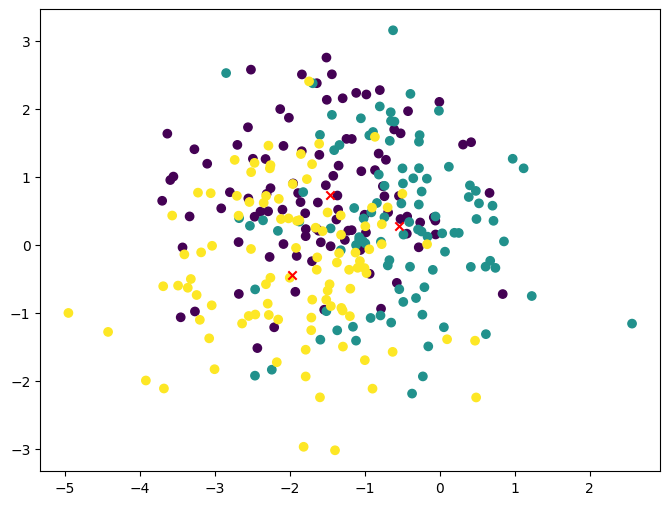

In [68]:
nk = 100
K = 3
var = 1
n = nk * K
d = 2
X = np.zeros((n, d))
y = np.zeros(n)

centroids = []

for k in range(K):
    mu = np.random.randn(d) * var
    centroids.append(mu)
    for i in range(nk):
        X[k * nk + i, :] = mu + np.random.randn(d)
        y[k * nk + i] = k

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.scatter([centroid[0] for centroid in centroids], [centroid[1] for centroid in centroids], marker='x', color='red')
plt.show()

10) Implement K-Means using the built-in methods from scikit-learn. You can use [this website](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) as a reference (by now you should be able to use scikit learn confidently). Plot the data points in the 2-dimensional space with their centroids and compare these to the predicted ones.

_Hint_: You can use *Kmeans.cluster_centers_* and *Kmeans.labels_* to extract the means and the variances resepectively

C:\Users\goali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


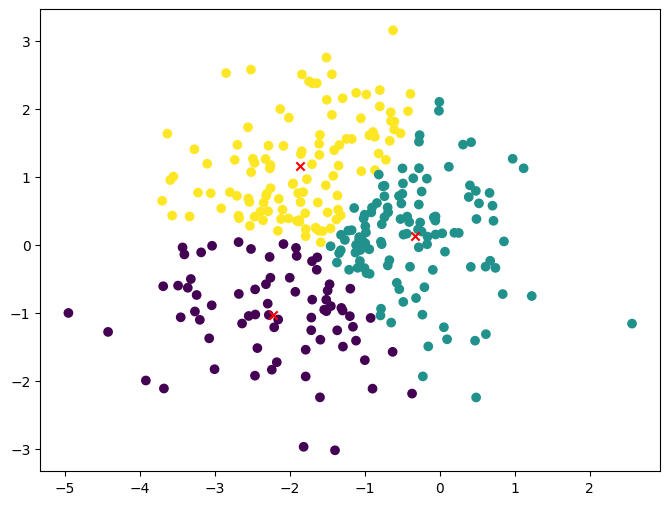

In [69]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=K)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', color='red')
plt.show()


11) Vary the variance $\sigma$ of each cluster and plot the detected cluster again with their centroids and colors assigned according to cluster membership. In which way are the predictions affected when the noise level is higher?

In [73]:
import warnings
warnings.filterwarnings("ignore")


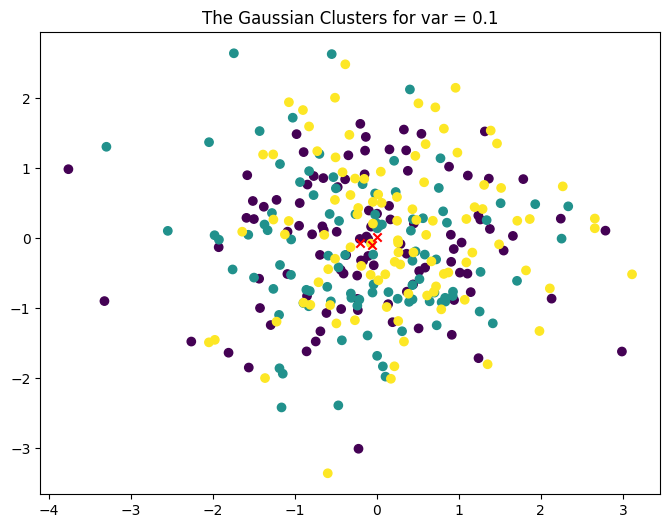

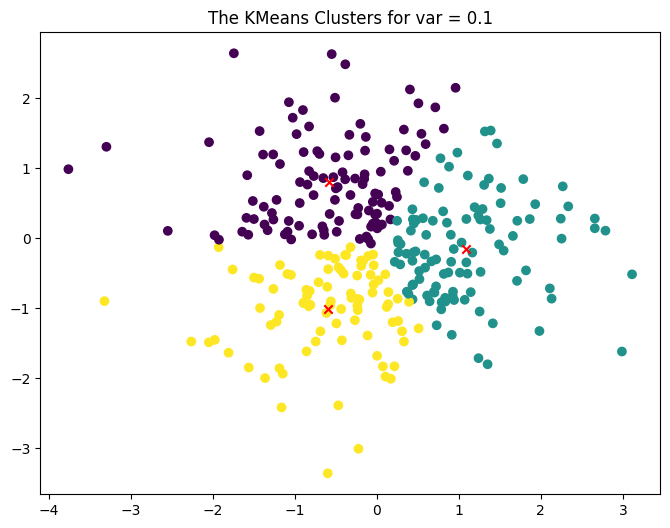

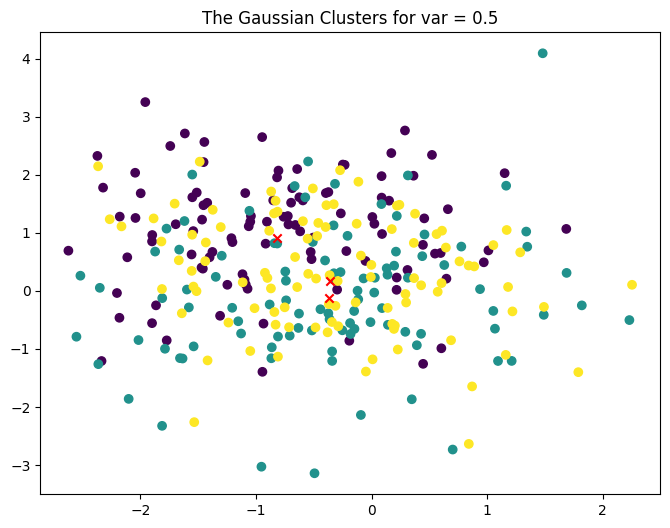

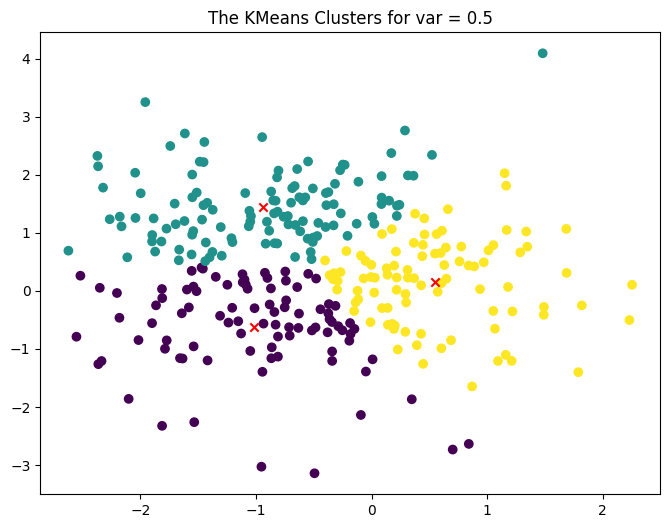

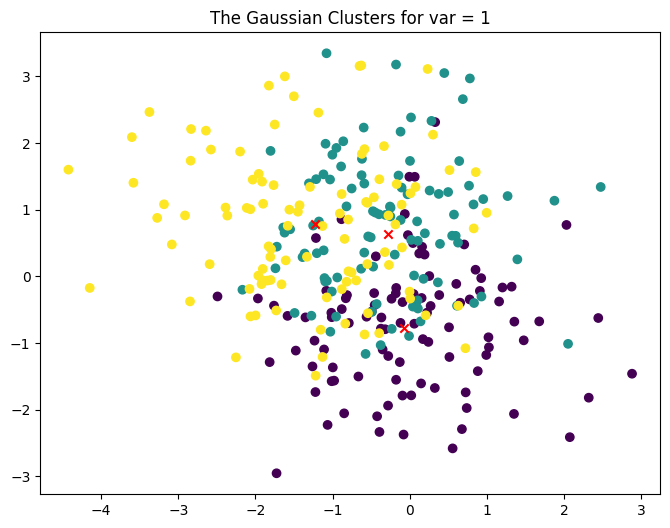

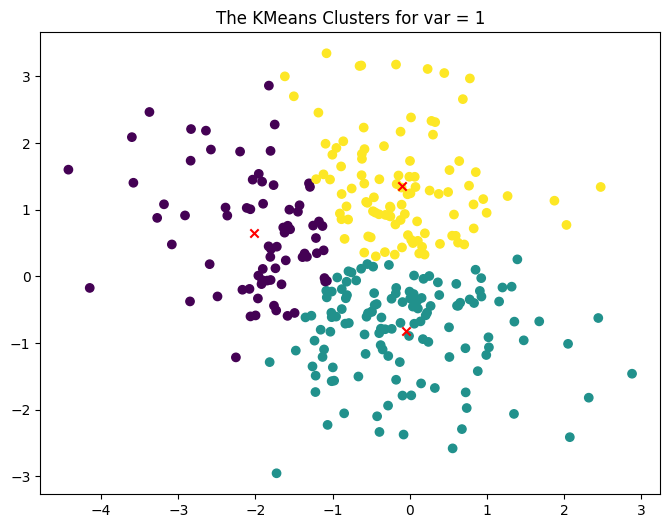

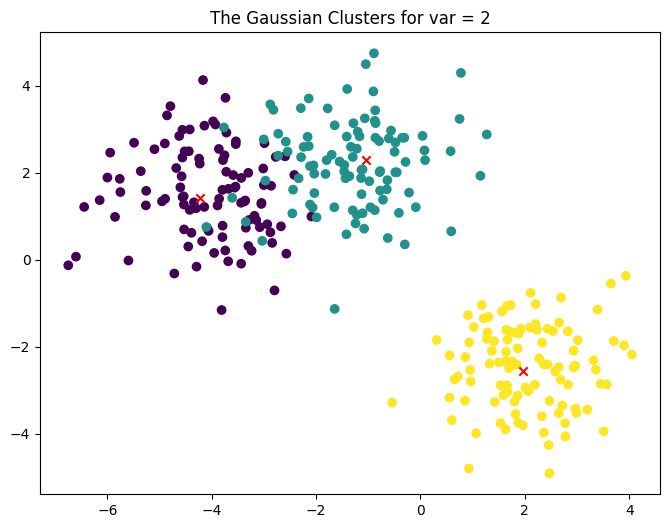

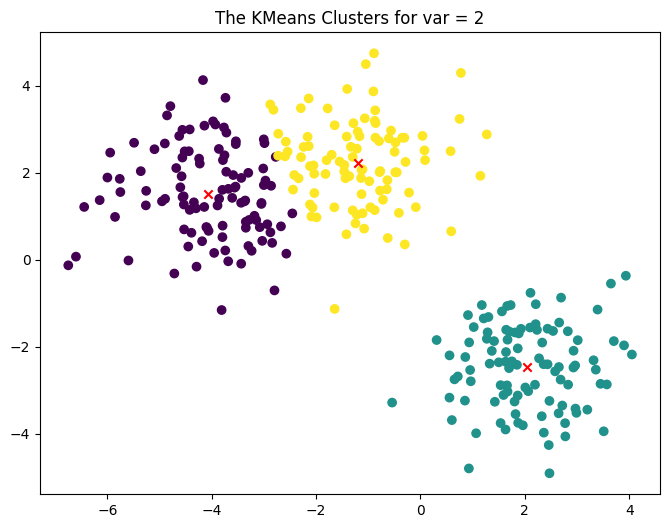

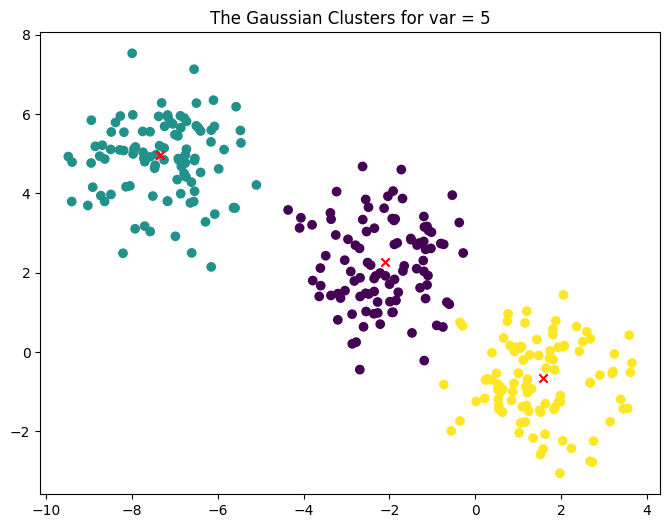

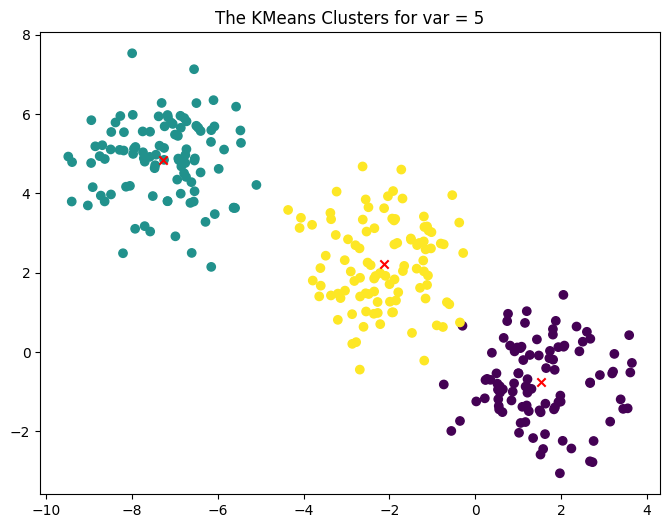

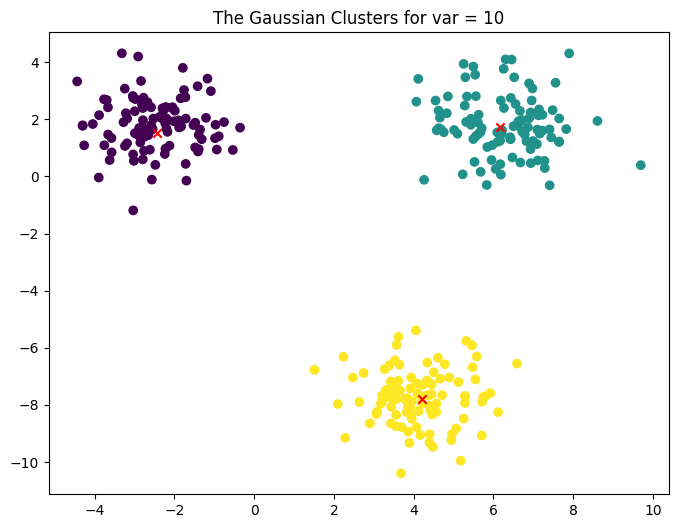

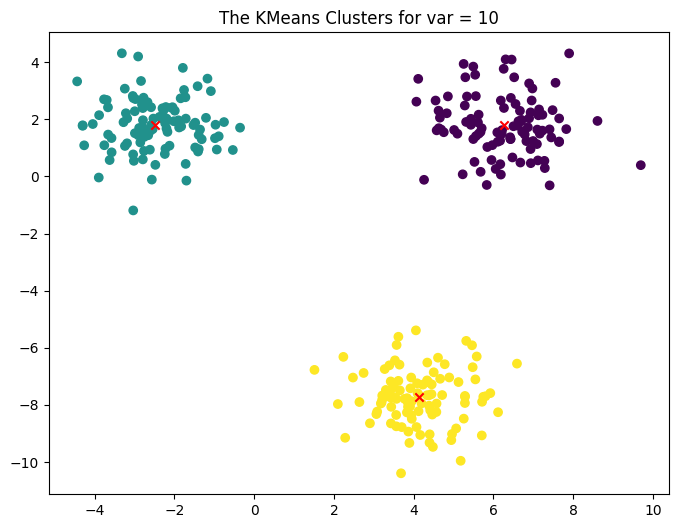

In [77]:
# your code here
var = [0.1,0.5,1,2,5,10]
for v in var:
    centroids = []
    for k in range(K):
        mu = np.random.randn(d) * v
        centroids.append(mu)
        for i in range(nk):
            X[k * nk + i, :] = mu + np.random.randn(d)
            y[k * nk + i] = k
    plt.figure(figsize=(8, 6))
    plt.title(f"The Gaussian Clusters for var = {v}")
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.scatter([centroid[0] for centroid in centroids], [centroid[1] for centroid in centroids], marker='x', color='red')
    plt.show()
    kmeans = KMeans(n_clusters=K)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    plt.figure(figsize=(8, 6))
    plt.title(f"The KMeans Clusters for var = {v}")
    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', color='red')
    plt.show()

More we augmente the variance we see that we have almost the clusters defined. But with small variance we have points that are everywhere and we see that Kmeans is a good tools to create goods clusters and we can obtain really good results for unsupervised Learning. 

When we increase Noise level we increase the clusters overlap, the clusters dispersion, and we have more outliers. So that make the clustering task for KMeans more challenging and so we decrease the accuracy of our model.


